### 1. Setting up the sagemaker and defining estimators
### In this step, we're importing all the required libraries and setting up the SageMaker environment to create a DeepAR forecasting estimator.


In [13]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = 'supply-chain-forecasting-18'
prefix = 'sagemaker/data'
region = boto3.Session().region_name
container = get_image_uri(region, 'forecasting-deepar')

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='deepar-forecast',
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sagemaker_session
)

[04/07/25 09:28:00] WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=944344;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=812406;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=646297;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=940429;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=507182;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=214640;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    WARNING  train_instance_count has been renamed in sagemaker>=2.              ]8;id=383548;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=903442;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_instance_type has been renamed in sagemaker>=2.               ]8;id=387308;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=966638;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

### 2. Setting hyperparameters for the model

In [14]:
estimator.set_hyperparameters(
    time_freq='D',
    context_length='30',
    prediction_length='30',
    num_cells='40',
    num_layers='3',
    likelihood='gaussian',
    epochs='100'
)

### 3. Specifying the location of training and testing data
### Training the model using the training and test data

In [17]:
data_channels = {
    "train": f"s3://{bucket}/{prefix}/train/",
    "test": f"s3://{bucket}/{prefix}/test/"
}

estimator.fit(data_channels)

[04/07/25 09:54:42] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=115816;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=581944;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=493562;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=354310;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             deepar-forecast-2025-04-07-09-54-42-471                                               

2025-04-07 09:54:44 Starting - Starting the training job...
2025-04-07 09:55:17 Downloading - Downloading input data...
2025-04-07 09:55:43 Downloading - Downloading the training image...............
2025-04-07 09:58:09 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[04/07/2025 09:58:22 INFO 140474014373696] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood

### 4. Deploying the trained model to sagemaker endpoint
### We deploy the trained DeepAR model to a SageMaker endpoint so we can make predictions in real-time.

In [18]:
from sagemaker.predictor import Predictor

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

print("Model deployed at endpoint:", predictor.endpoint_name)

[04/07/25 10:13:46] INFO     Creating model with name: deepar-forecast-2025-04-07-10-13-46-129      ]8;id=921644;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=127392;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=468503;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=638886;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             deepar-forecast-2025-04-07-10-13-46-129                                               

[04/07/25 10:13:47] INFO     Creating endpoint with name deepar-forecast-2025-04-07-10-13-46-129    ]8;id=621111;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=610766;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

--------!Model deployed at endpoint: deepar-forecast-2025-04-07-10-13-46-129


### 5. Downloading test data from s3 bucket
### Download the test.json file from the S3 bucket so it can be used for prediction locally.

In [19]:
bucket = 'supply-chain-forecasting-18'
s3 = boto3.client('s3')
s3.download_file(bucket, 'sagemaker/data/test/test.json', 'test.json')
print("test.json downloaded successfully into your notebook environment!")

test.json downloaded successfully into your notebook environment!


### 6. Making a forecast for one time series
### Here we are selecting one time series and sending it to the deployed endpoint to get forecast predictions.

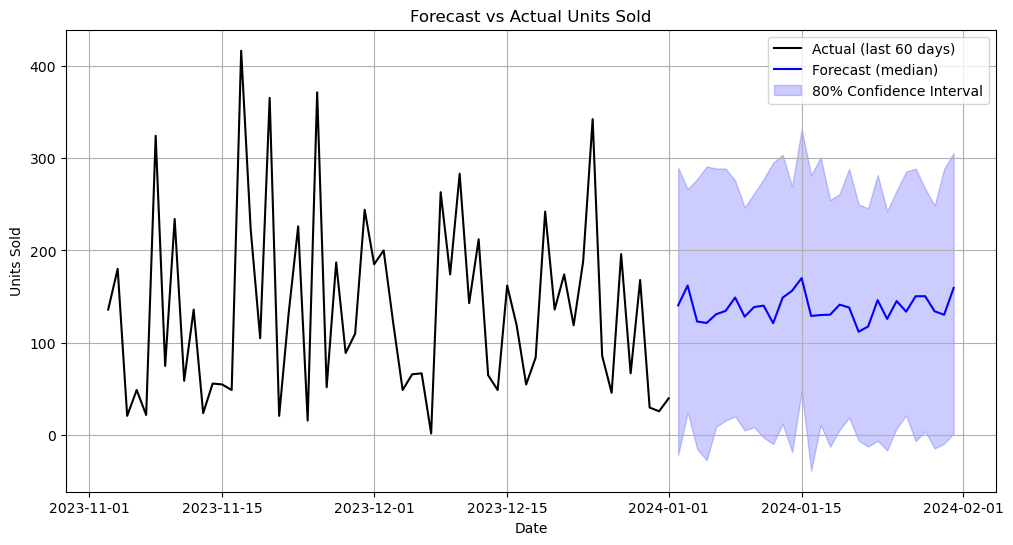

In [20]:
import pandas as pd
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

with open("test.json", "r") as f:
    test_series = [json.loads(line) for line in f]

series_to_forecast = test_series[0]

request_data = {
    "instances": [series_to_forecast],
    "configuration": {
        "num_samples": 100,
        "output_types": ["quantiles"],
        "quantiles": ["0.1", "0.5", "0.9"]
    }
}

response = predictor.predict(request_data)

forecast_index = pd.date_range(
    start=pd.to_datetime(series_to_forecast["start"]) + timedelta(days=len(series_to_forecast["target"])),
    periods=30,
    freq="D"
)

forecast_df = pd.DataFrame({
    "0.1": response['predictions'][0]['quantiles']['0.1'],
    "0.5": response['predictions'][0]['quantiles']['0.5'],
    "0.9": response['predictions'][0]['quantiles']['0.9'],
}, index=forecast_index)

# plotting the actual and forecasted data
plt.figure(figsize=(12,6))
past_index = pd.date_range(start=series_to_forecast["start"], periods=len(series_to_forecast["target"]), freq="D")
plt.plot(past_index[-60:], series_to_forecast["target"][-60:], label="Actual (last 60 days)", color='black')
plt.plot(forecast_index, forecast_df["0.5"], label="Forecast (median)", color='blue')
plt.fill_between(forecast_index, forecast_df["0.1"], forecast_df["0.9"], color='blue', alpha=0.2, label="80% Confidence Interval")
plt.legend()
plt.title("Forecast vs Actual Units Sold")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()


### 7. Forecasting all the time series and saving the results
### We now run forecasts for every time series in the test set and store the output in an Excel file.

In [21]:
with open("test.json", "r") as f:
    test_series = [json.loads(line) for line in f]

all_forecasts = []

for i, series in enumerate(test_series):
    try:
        request_data = {
            "instances": [series],
            "configuration": {
                "num_samples": 100,
                "output_types": ["quantiles"],
                "quantiles": ["0.1", "0.5", "0.9"]
            }
        }

        response = predictor.predict(request_data)
        prediction = response['predictions'][0]['quantiles']

        forecast_start = pd.to_datetime(series["start"]) + timedelta(days=len(series["target"]))
        forecast_index = pd.date_range(start=forecast_start, periods=30, freq="D")

        for j in range(30):
            all_forecasts.append({
                "Series Index": i,
                "Forecast Date": forecast_index[j].strftime('%Y-%m-%d'),
                "p10": prediction["0.1"][j],
                "p50": prediction["0.5"][j],
                "p90": prediction["0.9"][j]
            })

    except Exception as e:
        print(f"Forecast failed for series {i}: {e}")

forecast_df = pd.DataFrame(all_forecasts)
excel_filename = "all_forecasts.xlsx"
forecast_df.to_excel(excel_filename, index=False)
print(f"Forecasts saved to '{excel_filename}'")

Forecasts saved to 'all_forecasts.xlsx'


### 8. Downloading original data from s3 for creating mapping
### We download the original CSV from S3 to map forecasts back to their store and product IDs.

In [31]:
import boto3

s3 = boto3.client("s3")
bucket = "supply-chain-forecasting-18"

s3.download_file(bucket, 'sagemaker/data/original/retail_store_inventory.csv', 'retail_store_inventory.csv')
print(" retail_store_inventory.csv downloaded to your notebook!")

 retail_store_inventory.csv downloaded to your notebook!


### 9. Creating a mapping for store/product using original dataset
### We use the downloaded CSV to generate a mapping of Store ID and Product ID for each time series.

In [32]:
import pandas as pd

df = pd.read_csv("retail_store_inventory.csv")
df['Date'] = pd.to_datetime(df['Date'])

grouped = df.groupby(['Store ID', 'Product ID', 'Date'])['Units Sold'].sum().reset_index()
sorted_groups = grouped.groupby(['Store ID', 'Product ID'])

series_mapping = [(store, product) for (store, product), _ in sorted_groups]
mapping_df = pd.DataFrame(series_mapping, columns=["Store ID", "Product ID"])
mapping_df["Series Index"] = mapping_df.index

mapping_df.to_excel("series_mapping.xlsx", index=False)
print("Mapping file created as 'series_mapping.xlsx'")


Mapping file created as 'series_mapping.xlsx'


### 10. Merging the forecasted values with original store-product mapping  
### We combine the forecast results with their original Store ID and Product ID to get the final forecast file.

In [33]:
forecast_df = pd.read_excel("all_forecasts.xlsx")
mapping_df = pd.read_excel("series_mapping.xlsx")

merged_df = pd.merge(forecast_df, mapping_df, on="Series Index", how="left")
merged_df = merged_df[["Store ID", "Product ID", "Forecast Date", "p10", "p50", "p90"]]

merged_df.to_excel("final_forecast_output.xlsx", index=False)
print("Final merged file saved as 'final_forecast_output.xlsx'")

Final merged file saved as 'final_forecast_output.xlsx'
